# Testing and regularization with Turi Create

In [21]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
random.seed(0)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from utils import *

Defining our dataset

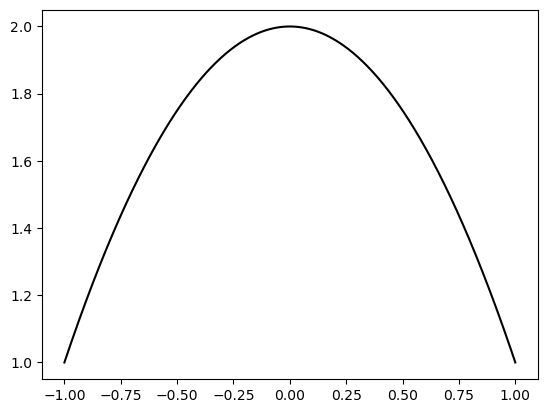

In [2]:
# Our original polynomial is -x^2+1
coefs = [2,0,-1]

def polynomial(coefs, x):
    n = len(coefs)
    return sum([coefs[i]*x**i for i in range(n)])

def draw_polynomial(coefs):
    n = len(coefs)
    x = np.linspace(-1, 1, 1000)
    #plt.ylim(0,3)
    plt.plot(x, sum([coefs[i]*x**i for i in range(n)]), linestyle='-', color='black')

draw_polynomial(coefs)

Generating a dataset of 40 points, close to this polynomial

In [3]:
X = []
Y = []
for i in range(40):
    x = random.uniform(-1,1)
    y = polynomial(coefs, x) + random.gauss(0,0.1)
    X.append(x)
    Y.append(y)

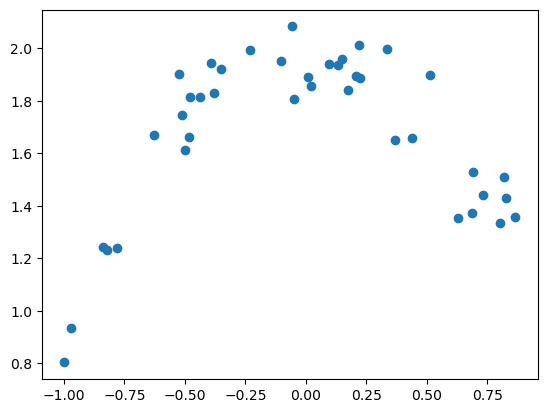

In [4]:
plt.scatter(X, Y)

Training a polynomial regression model
Let's plot a polynomial of degree 30 to our dataset. Notice how much it overfits!

In [5]:
def train_polynomial_regression(X, Y, degree):
    """
    Trains a polynomial regression model, and returns weights

    Args:
      X: Input features (list or numpy array).
      Y: Input labels (list or numpy array).
      degree: The degree of the polynomial.

    Returns:
      A tuple containing:
        - The weights (coefficients) of the trained model (numpy array).
        - The intercept of the trained model (float).
    """
    X = np.array(X).reshape(-1, 1)
    Y = np.array(Y)

    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, Y)

    return model, model.coef_, model.intercept_

In [6]:
degree_used = 30
model_30, coefficients_30, intercept_30 = train_polynomial_regression(X, Y, degree_used)
print(f"Polynomial Regression (Degree {degree_used}) Coefficients: {coefficients_30}")
print(f"Polynomial Regression (Degree {degree_used}) Intercept: {intercept_30}")

Polynomial Regression (Degree 30) Coefficients: [-1.42989096e+09 -1.47605316e+00  1.04873056e+01  3.24171340e+02
 -1.95158695e+02 -2.53598106e+04 -1.58513948e+04  8.73493347e+05
  8.01415188e+05 -1.61532999e+07 -1.56235630e+07  1.81623114e+08
  1.68346528e+08 -1.33603283e+09 -1.13390409e+09  6.70611710e+09
  5.07886310e+09 -2.34750036e+10 -1.56576574e+10  5.77006695e+10
  3.38219736e+10 -9.89030613e+10 -5.13836464e+10  1.15488925e+11
  5.41724105e+10 -8.74174156e+10 -3.80225784e+10  3.86241526e+10
  1.60809902e+10 -7.55720157e+09 -3.11248343e+09]
Polynomial Regression (Degree 30) Intercept: 1429890965.903636


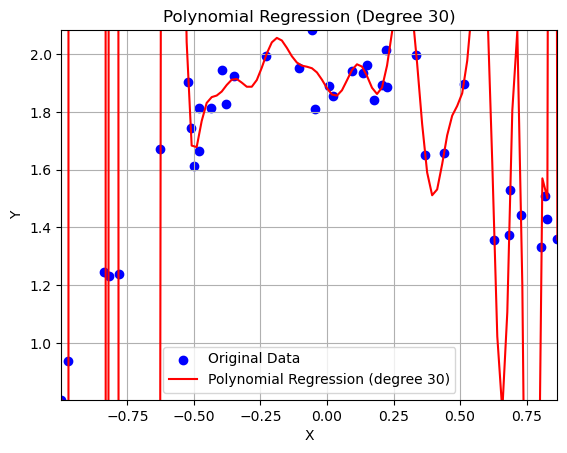

In [7]:
utils.plot_polynomial_regression(X, Y, degree_used, model_30)

Splitting data into training and testing

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

print("Shape of X_train:", np.shape(X_train))
print("Shape of X_test:", np.shape(X_test))
print("Shape of Y_train:", np.shape(Y_train))
print("Shape of Y_test:", np.shape(Y_test))

Shape of X_train: (32,)
Shape of X_test: (8,)
Shape of Y_train: (32,)
Shape of Y_test: (8,)


Training a polynomial regression model with no regularization

In [16]:
def train_and_plot_polynomial_regression(X, Y, degree):
    X = np.array(X).reshape(-1, 1)
    Y = np.array(Y)

    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    model = LinearRegression()
    model.fit(X_poly, Y)

    # Generate predicted values for plotting the curve
    X_plot = np.linspace(np.min(X), np.max(X), 100).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)
    Y_plot_poly = model.predict(X_plot_poly)

    # Plot the original points
    plt.scatter(X, Y, color='blue', label='Original Data')

    # Plot the polynomial regression curve
    plt.plot(X_plot, Y_plot_poly, color='red', label=f'Polynomial Regression (degree {degree})')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Polynomial Regression (Degree {degree})')
    plt.legend()
    plt.grid(True)

    # Set plot bounds based on X and Y
    plt.xlim(np.min(X), np.max(X))
    plt.ylim(np.min(Y), np.max(Y))

    plt.show()

    return model.coef_, model.intercept_

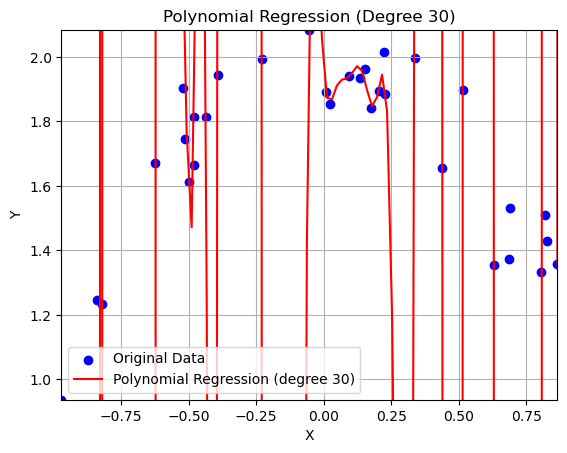

In [17]:
coefficients_and_intercept = train_and_plot_polynomial_regression(X_train, Y_train, degree_used)

In [19]:
def predict_and_evaluate(model_coefficients, degree, X_train, Y_train, X_test, Y_test):
    X_train = np.array(X_train).reshape(-1, 1)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test).reshape(-1, 1)
    Y_test = np.array(Y_test)

    coefs = model_coefficients[0] # model_coefficients is a tuple (coef_, intercept_)
    intercept = model_coefficients[1]

    # Reconstruct the polynomial transformation for prediction
    poly = PolynomialFeatures(degree=degree)
    # Fit on the combined data range to ensure the transformation is consistent
    poly.fit(np.concatenate((X_train, X_test)))

    X_test_poly = poly.transform(X_test)


    # Build the prediction manually using the coefficients and degree.
    # The intercept is the coefficient for the x^0 term
    y_pred = X_test_poly @ coefs.reshape(-1, 1) + intercept

    # Calculate the mean squared error
    mse = mean_squared_error(Y_test, y_pred)

    # Plotting
    plt.figure(figsize=(8, 6))

    # Plot training points
    plt.scatter(X_train, Y_train, color='blue', label='Training Data')

    # Plot testing points
    plt.scatter(X_test, Y_test, color='orange', marker='^', label='Testing Data')

    # Generate points for plotting the regression curve over the entire range of data
    X_plot = np.linspace(np.min(np.concatenate((X_train, X_test))), np.max(np.concatenate((X_train, X_test))), 200).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)

    # Calculate predictions for the plot
    y_plot_pred = X_plot_poly @ coefs.reshape(-1, 1) + intercept


    # Plot the polynomial regression curve
    # Ensure the plot color is red here
    plt.plot(X_plot, y_plot_pred.flatten(), color='red', label=f'Polynomial Regression (degree {degree})')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Polynomial Regression (Degree {degree}) with Train/Test Data')
    plt.legend()
    plt.grid(True)

    # Set plot bounds based on the range of all data (train + test)
    all_Y = np.concatenate((Y_train, Y_test))
    min_y = np.min(all_Y)
    max_y = np.max(all_Y)

    # Add a little padding to the y-limits
    padding = (max_y - min_y) * 0.1
    plt.xlim(np.min(np.concatenate((X_train, X_test))), np.max(np.concatenate((X_train, X_test))))
    plt.ylim(min_y - padding, max_y + padding)


    plt.show()


    return mse

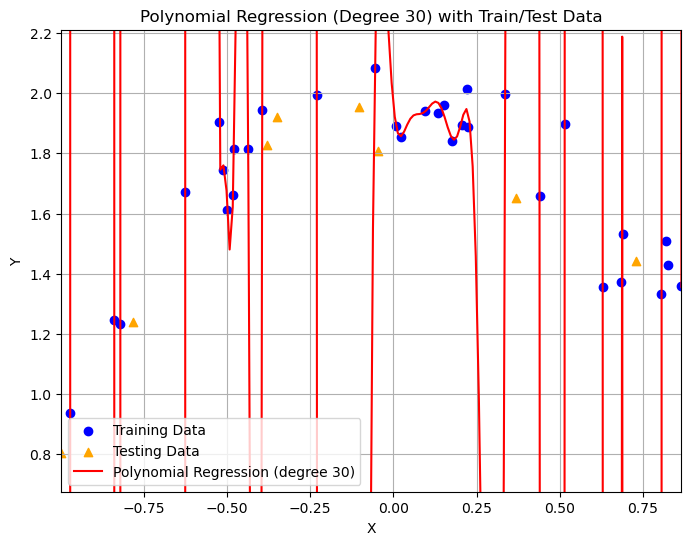

Square loss on the test set (degree 30): 8.463434818604166e+18


In [20]:
square_loss = predict_and_evaluate(coefficients_and_intercept, degree_used, X_train, Y_train, X_test, Y_test)
print(f"Square loss on the test set (degree {degree_used}): {square_loss}")

Training a polynomial regression model with L1 regularization

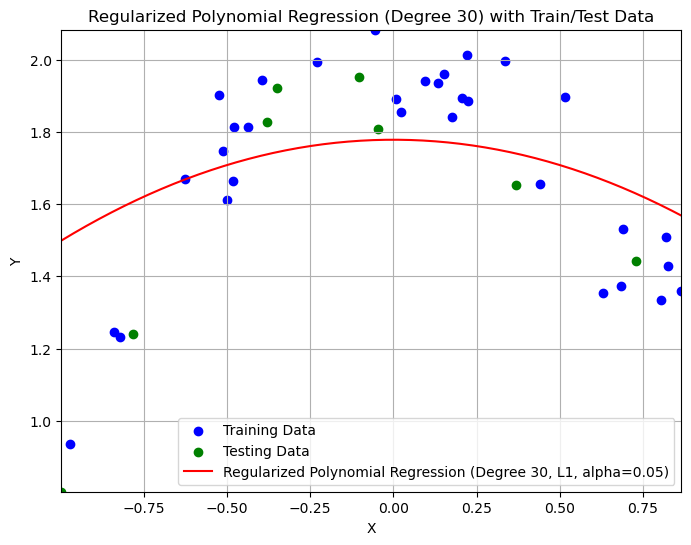

RMSE with L1 Regularization (degree 30, alpha=0.05): 0.3027448878333735


In [22]:
alpha_value = 0.05 # Example alpha value for regularization

# Train with L1 (Lasso) regularization
rmse_lasso = train_and_plot_regularized_polynomial_regression(X_train, Y_train, X_test, Y_test, degree_used, regularization_type='L1', alpha=alpha_value)
print(f"RMSE with L1 Regularization (degree {degree_used}, alpha={alpha_value:.2f}): {rmse_lasso}")

Training a polynomial regression model with L2 regularization

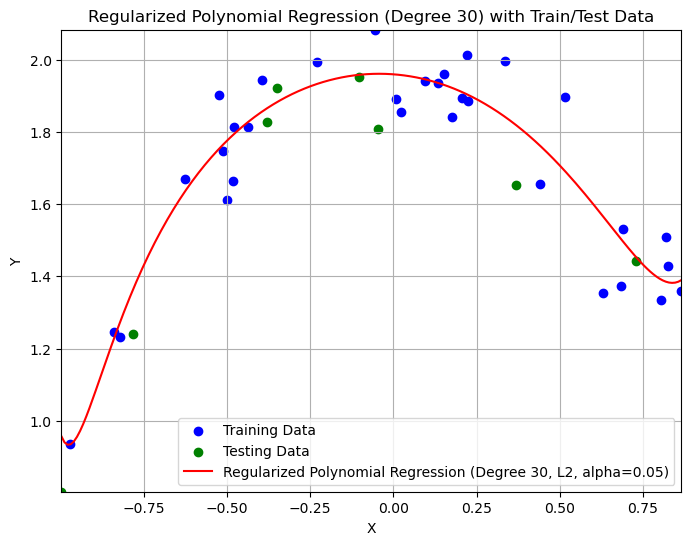

RMSE with L2 Regularization (degree 30, alpha=0.05): 0.10800013182491369


In [23]:
alpha_value = 0.05 # Example alpha value for regularization

# Train with L2 (Ridge) regularization
rmse_ridge = train_and_plot_regularized_polynomial_regression(X_train, Y_train, X_test, Y_test, degree_used, regularization_type='L2', alpha=alpha_value)
print(f"RMSE with L2 Regularization (degree {degree_used}, alpha={alpha_value:.2f}): {rmse_ridge}")